## Assignment 1 

### Qian Zhang

In [1]:
# import the packages

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
from scipy.stats import gaussian_kde
import timeit
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity
import multiprocessing
from dask import compute, delayed
import dask.multiprocessing

### Question 1

In [2]:
# load the covid19 data

covid_df=pd.read_csv('data/COVIDincubation.txt')
covid_df.head()

,gender,age,symp_days
0,F,52.0,5.0
1,M,42.0,6.5
2,F,32.0,3.0
3,M,22.0,4.0
4,M,41.0,8.0


### 1.(a)

In [3]:
# extract the column of symp_days and three groups

symp_days=covid_df['symp_days'].values
symp_days_young=covid_df[covid_df['age']<=40]['symp_days'].values
symp_days_old=covid_df[covid_df['age']>40]['symp_days'].values

Text(0.5, 1.0, 'Histogram of days until symptons (Full sample)')

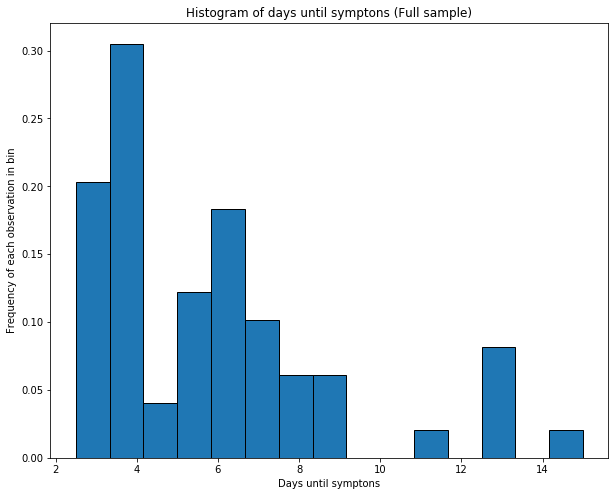

In [4]:
# plot the full sample hist

plt.figure(figsize=(10,8))
n_tot,bin_cuts,patches = plt.hist (symp_days, 15, density=True, edgecolor='black')
plt.xlabel('Days until symptons')
plt.ylabel('Frequency of each observation in bin')
plt.title('Histogram of days until symptons (Full sample)')

Text(0.5, 1.0, 'Histogram of days until symptons (Young)')

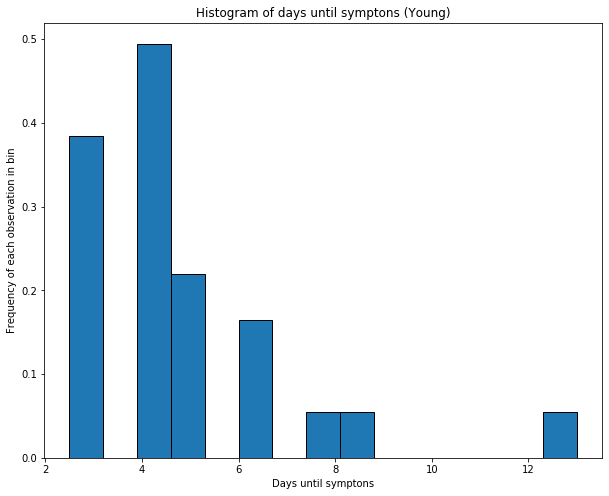

In [5]:
# plot the young sample hist

plt.figure(figsize=(10,8))
n_tot,bin_cuts,patches = plt.hist (symp_days_young, 15, density=True, edgecolor='black')
plt.xlabel('Days until symptons')
plt.ylabel('Frequency of each observation in bin')
plt.title('Histogram of days until symptons (Young)')

Text(0.5, 1.0, 'Histogram of days until symptons (Old)')

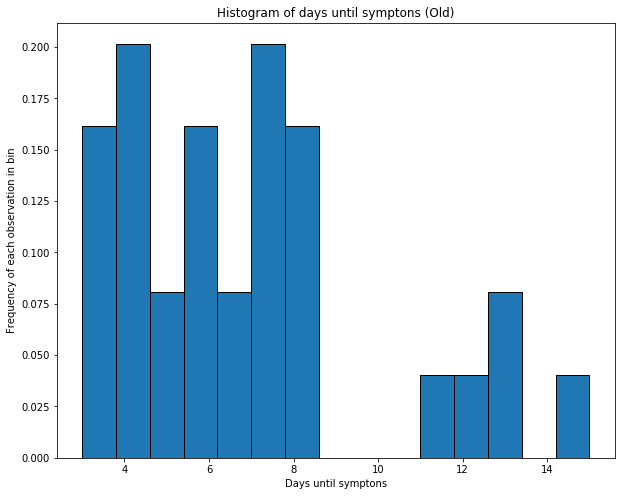

In [6]:
# plot the old sample hist

plt.figure(figsize=(10,8))
n_tot,bin_cuts,patches = plt.hist (symp_days_old, 15, density=True, edgecolor='black')
plt.xlabel('Days until symptons')
plt.ylabel('Frequency of each observation in bin')
plt.title('Histogram of days until symptons (Old)')

### 1.(b)

In [7]:
# choose a optimal bandwidth via cross-validation for three groups (full, young, old)

bandwidths = 10 ** np.linspace(-1, 1, 500)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())

# for full sample

grid.fit(symp_days.reshape((59,1)))
band_tot=grid.best_params_["bandwidth"]

# for young people (<=40)

grid.fit(symp_days_young.reshape((len(symp_days_young),1)))
band_young=grid.best_params_["bandwidth"]

# for old people (>40)

grid.fit(symp_days_old.reshape((len(symp_days_old),1)))
band_old=grid.best_params_["bandwidth"]

In [8]:
print('Optimal bandwidth for full sample is {}.\nOptimal bandwidth for young sample is {}.\nOptimal bandwidth for old sample is {}.'.format(band_tot,band_young,band_old))

Optimal bandwidth for full sample is 0.8910453324821516.
Optimal bandwidth for young sample is 1.6233824316122782.
Optimal bandwidth for old sample is 1.1861737164524786.


In [9]:
# prepare the plot

x_pts=np.linspace(0.01,21,1000).reshape((1000,1))

# full sample

kde_tot=KernelDensity(bandwidth=band_tot,kernel='gaussian')
kde_tot.fit(symp_days.reshape((59,1)))
logprob_tot=kde_tot.score_samples(x_pts).reshape((1000,1))

# young sample

kde_young=KernelDensity(bandwidth=band_young,kernel='gaussian')
kde_young.fit(symp_days_young.reshape((len(symp_days_young),1)))
logprob_young=kde_young.score_samples(x_pts).reshape((1000,1))

# old sample

kde_old=KernelDensity(bandwidth=band_old,kernel='gaussian')
kde_old.fit(symp_days_old.reshape((len(symp_days_old),1)))
logprob_old=kde_old.score_samples(x_pts).reshape((1000,1))

Text(0.5, 1.0, 'KDE distribtion fitting the days until symptons')

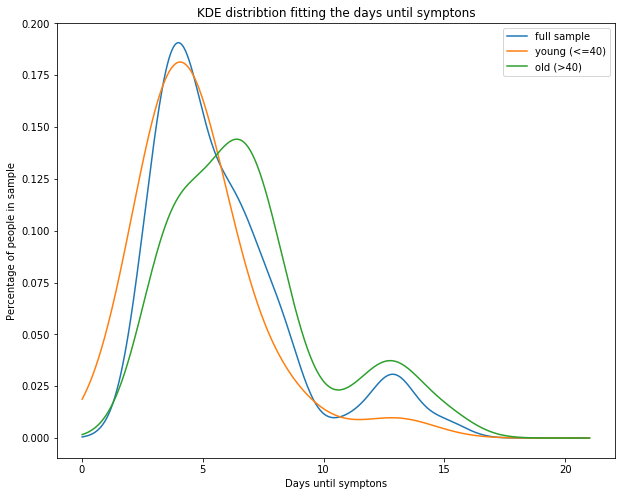

In [10]:
# draw the plot

plt.figure(figsize=(10,8))
ax=plt.gca()

ax.plot(x_pts,np.exp(logprob_tot),label='full sample')
ax.plot(x_pts,np.exp(logprob_young),label='young (<=40)')
ax.plot(x_pts,np.exp(logprob_old),label='old (>40)')
plt.legend()
plt.xlabel('Days until symptons')
plt.ylabel('Percentage of people in sample')
plt.title('KDE distribtion fitting the days until symptons')

### 1.(c)

From the figure above, we can see that the distributions of incubation period between young (<=40) and old (>40) group are quite different. The distribution for young people has the peak at 5 days, and the variance is relatively small. The distribution for old people has a larger variance. It has two peaks around 7 and 13 days. Therefore, we conclude that based on the sample, the young and old people should be treated differently. Also, the incubation period of young people in general is shorter than that of old people. Moreover, both groups (also full sample) has the maximum incubation period about 17 days, which accords to the current quarantine of about two weeks.

### Question 2

In [11]:
# load the data

bq_data = np.loadtxt('data/BQ_probmat.txt', delimiter=',')

In [12]:
# Some diagnostics

print('Shape of BQmat_orig data', bq_data.shape)
print('Bequest distribution by income group:',
      bq_data.sum(axis=0))
print('Sum of all probabilities', bq_data.sum())

Shape of BQmat_orig data (73, 7)
Bequest distribution by income group: [0.01214584 0.00817072 0.01590964 0.0139963  0.01383075 0.06927237
 0.86667437]
Sum of all probabilities 1.0000000000000002


As the sum of probabilities is already 1, no more normalizing is needed.

### 2.(a)

Text(0.5, 0, 'Percent of BQ received')

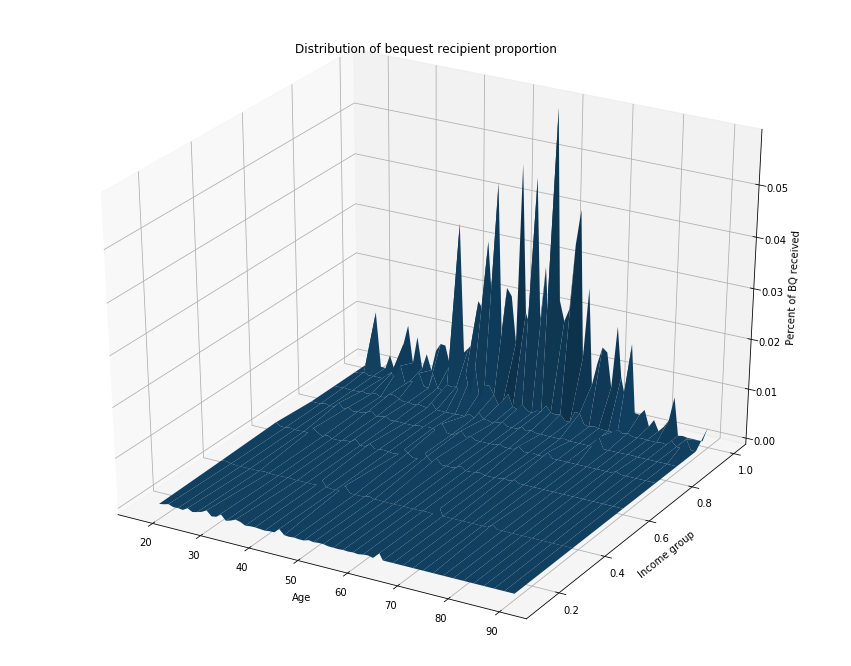

In [13]:
#Make 3D surface plot

age_vec = np.arange(18, 91)
lambdas = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
lambdas_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85,
                          0.94, 0.995])

income_mat, age_mat = np.meshgrid(lambdas_mdpts, age_vec)

fig = plt.figure(figsize=(15,12))
ax = fig.gca(projection='3d')
ax.plot_surface(age_mat, income_mat, bq_data)
ax.set_title('Distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Income group')
ax.set_zlabel('Percent of BQ received')

### 2.(b)

In [14]:
# load in the ind_data

ind_df = pd.read_csv('data/BQ_ind_data.txt', delimiter=',')
ind_df.head()

,age,income_pctl
0,18,0.125
1,18,0.125
2,18,0.125
3,18,0.125
4,18,0.125


To choose a good lambda, we can see from the chart in 2(a) that regarding the income level, the bottom 80%-90% of the people have similar percentage of BQ received, while the top 10-15% have a sharp increase in the percentage of BQ. Such a pattern may suggest a low bandwidth value. However, the lambda should also not be too low, as it may cause overfitting problem, and we want to smooth the curves to some degrees. 

Therefore, I would like to plot a series of plots with lambda from 0 to 1, step 0.05, and check under which lambda value does the plot make a good tradeoff between overfitting and underfitting. 

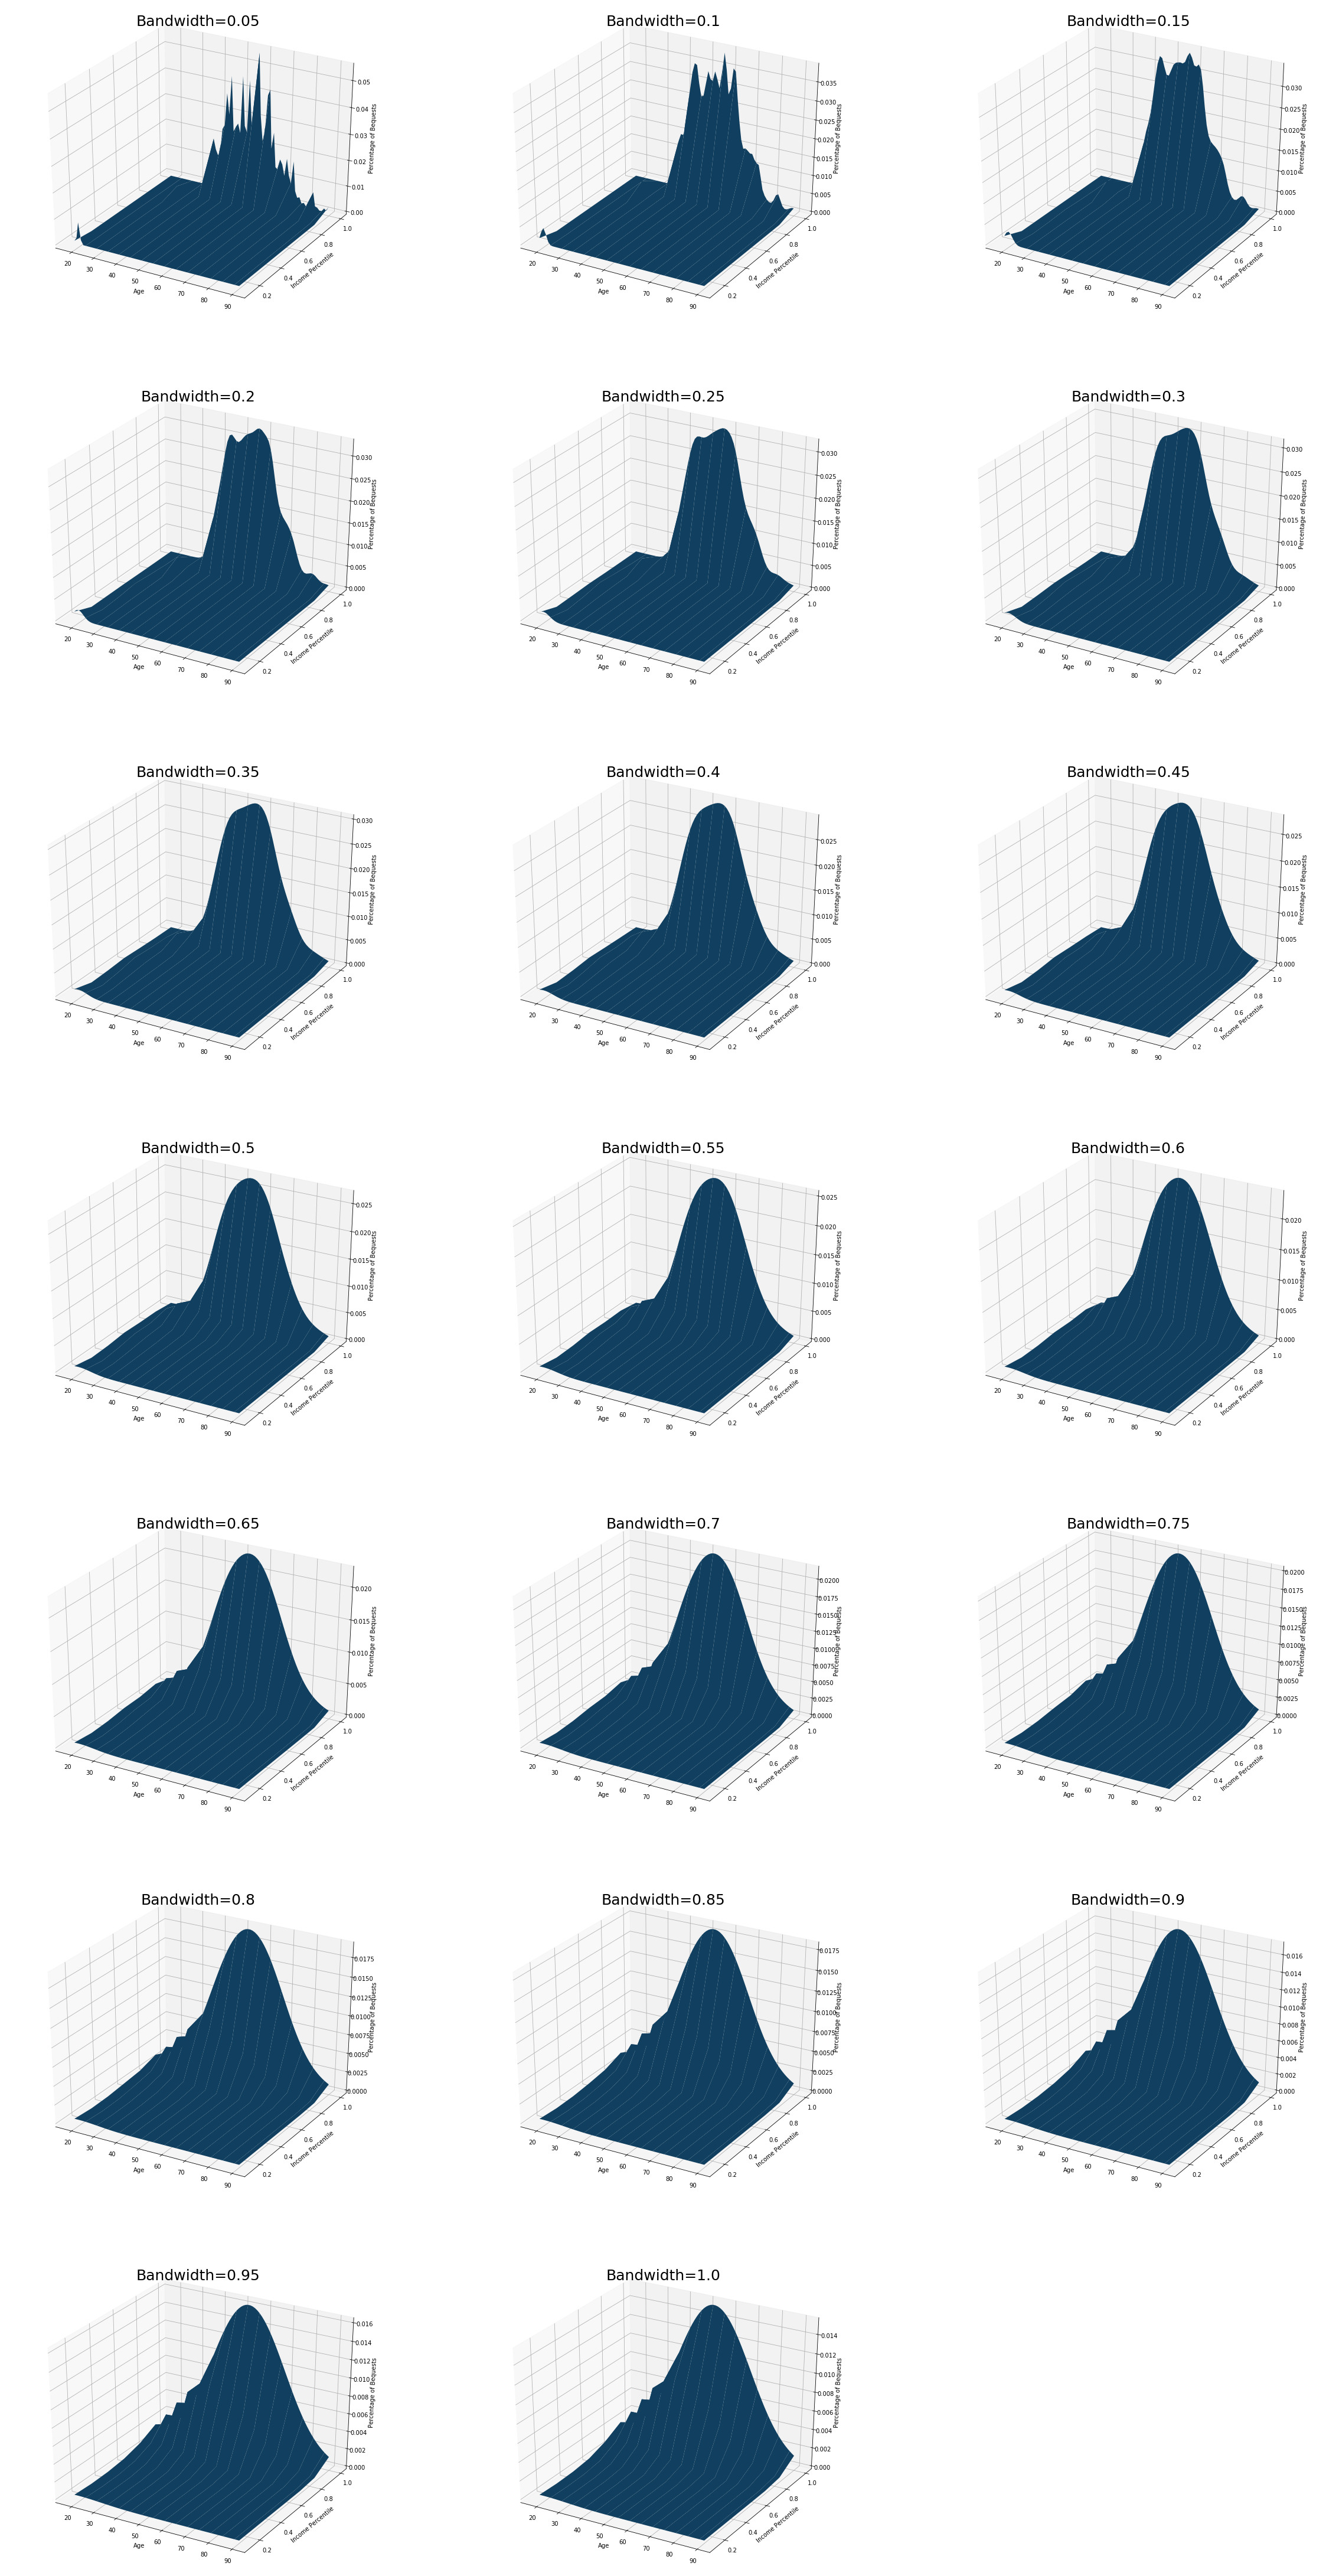

In [15]:
# plot the fitting plot with different lambdas

fig=plt.figure(figsize=(40,80))
gs = fig.add_gridspec(7, 3)

bandwidth=0.0
for i in range(7):
    
    for j in range(3):
        
        bandwidth +=0.05
        
        kernel = gaussian_kde(ind_df.T, bw_method=bandwidth)

        age_min = ind_df['age'].min()
        age_max = ind_df['age'].max()
        income_min = ind_df['income_pctl'].min()
        income_max = ind_df['income_pctl'].max()

        age_i, inc_i = np.mgrid[age_min:age_max:73j,
                                      income_min:income_max:7j]
        coords = np.vstack([item.ravel() for item in [age_i, inc_i]])

        Z = np.reshape(kernel(coords), age_i.shape)
        Z_scaled = Z / float(np.sum(Z))

        ax = fig.add_subplot(gs[i,j], projection='3d')
        ax.plot_surface(age_i, inc_i, Z_scaled, rstride=5)
        ax.set_xlabel("Age")
        ax.set_ylabel("Income Percentile")
        ax.set_zlabel("Percentage of Bequests")
        ax.set_title(r'Bandwidth={}'.format(round(bandwidth,2)),fontsize=25)
        np.vstack([item.ravel() for item in [age_i, inc_i]])
        if int(bandwidth)==1:
            break
    
    if int(bandwidth)==1:
        break

From the series of plots above, I consider $\lambda$=0.25 as the best bandwidth. As we can see, when the bandwidth goes beyond 0.25, some curves become over-smooth, failing to capture some features that are supposed to be included.  In other words, the underfitting problem emerges and become more severe when bandwidth goes beyond 0.3.

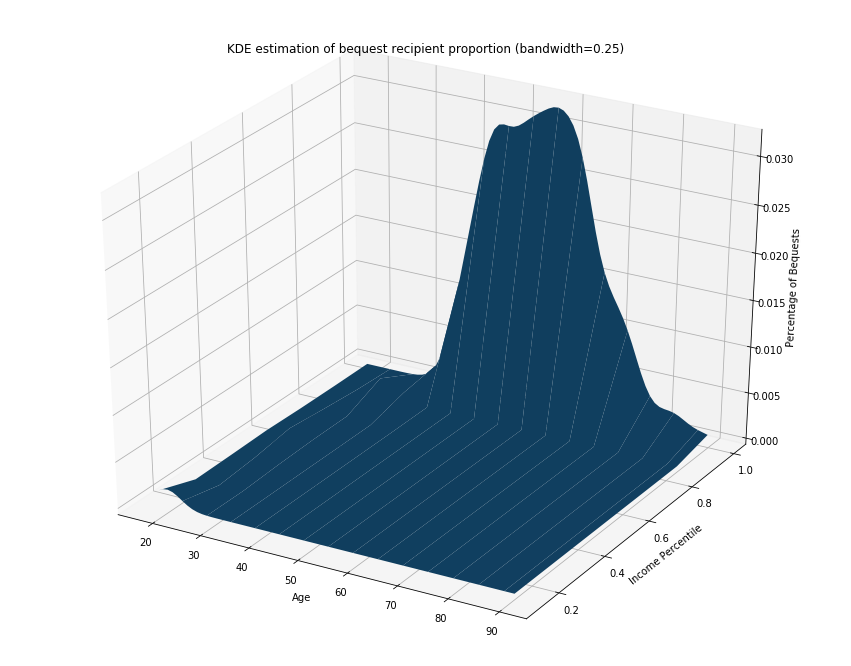

In [16]:
# fit the KDE with bandwidth = 0.25

fig=plt.figure(figsize=(15,12))

bandwidth=0.25

kernel = gaussian_kde(ind_df.T, bw_method=bandwidth)

age_min = ind_df['age'].min()
age_max = ind_df['age'].max()
income_min = ind_df['income_pctl'].min()
income_max = ind_df['income_pctl'].max()

age_i, inc_i = np.mgrid[age_min:age_max:73j,
                                      income_min:income_max:7j]
coords = np.vstack([item.ravel() for item in [age_i, inc_i]])

Z = np.reshape(kernel(coords), age_i.shape)
Z_scaled = Z / float(np.sum(Z))
ax = fig.gca(projection='3d')
ax.plot_surface(age_i, inc_i, Z_scaled, rstride=5)
ax.set_xlabel("Age")
ax.set_ylabel("Income Percentile")
ax.set_zlabel("Percentage of Bequests")
ax.set_title(r'KDE estimation of bequest recipient proportion (bandwidth=0.25)'.format(round(bandwidth,2)))
np.vstack([item.ravel() for item in [age_i, inc_i]])
plt.show()

In [17]:
# calc the estimated density

print('The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is about\n{}.'.format(round(Z_scaled[61-18+1][5],9)))

The estimated density for bequest recipients who are age 61 in the 6th lifetime income category is about
1.5e-07.
